Hunter Bennett | Glass Lab | Brain Aging Project | 27 Feb 2021

Goal of this notebook is to compare H3K27Ac correlations across cell types from human and mouse replicates. Hypothesis is that mouse nuclei are more similar to human nuclei of the same cell type than human nuclei of a different cell type.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

### Set working paths

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Read in color scheme dictionary

In [3]:
hex_dict={}
rgb_dict={}
for line in open('/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]    

# Read in promoter H3K27Ac

Mouse

In [9]:
# import annotation file
mus_df, mus_mat = read_annotated_peaks('./merged_peaks/ann_norm_promoters.txt')

# pull gene name for merging - capitalize to match human gene names
mus_df = mus_df.set_index('Gene Name')
mus_df.index = mus_df.index.str.upper()

# extract matrix
mus_mat = mus_df.loc[:, mus_df.columns.str.contains('H3K27')]

Human

In [11]:
# import annotation file
hum_df, hum_mat = read_annotated_peaks('./merged_peaks/human_ann_norm_promoters.txt')

# pull gene name for merging - capitalize to match human gene names
hum_df = hum_df.set_index('Gene Name')

# extract matrix
hum_mat = hum_df.loc[:, hum_df.columns.str.contains('H3K27ac')]

### Assess cross-species correlation

In [13]:
corr_dict = {}

In [24]:
for i in mus_mat.columns:
    # sort values highest first, this way the first entry of any gene
    # will come first in the list
    mus_filt = mus_mat[i].sort_values(ascending=False)
    # filter duplicates, keeping the first instance which is the highest expressed
    mus_filt = mus_filt[~mus_filt.index.duplicated()]

    corr_list = []
    for j in hum_mat.columns:
        # sort values highest first, this way the first entry of any gene
        # will come first in the list
        hum_filt = hum_mat[j].sort_values(ascending=False)
        # filter duplicates, keeping the first instance which is the highest expressed
        hum_filt = hum_filt[~hum_filt.index.duplicated()]

        # merge data frames
        merge_df = pd.merge(mus_filt,
                            hum_filt,
                            left_index=True,
                            right_index=True,
                            how='inner')

        corr_list.append(merge_df.corr(method='spearman').values[0,1])

    corr_dict[i] = corr_list

In [110]:
merge_df.shape

(15745, 2)

In [122]:
df = pd.DataFrame(corr_dict, index=hum_mat.columns.tolist())
df.index = df.index.str.split('/').str[-1].str.split('_ChIP').str[0]
df.columns = df.columns.str.split('/').str[-1].str.split('_ChIP').str[0]

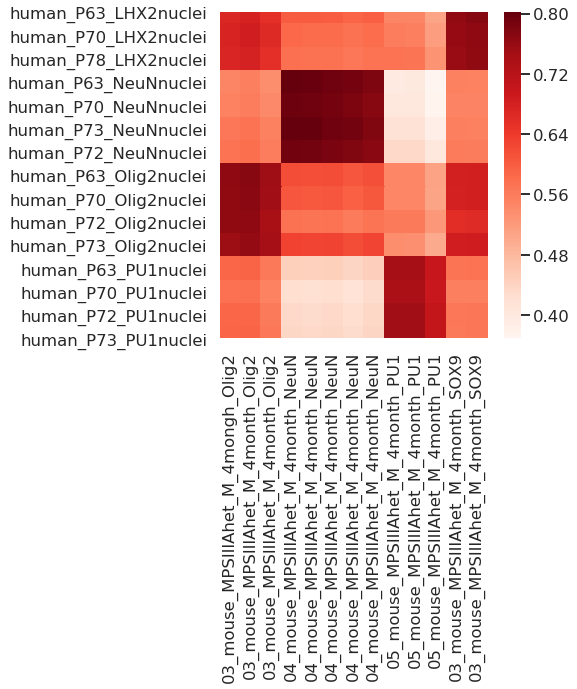

In [123]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df,
            cmap='Reds',
            ax=ax)

In [45]:
# sox9 astrocytes
sox9_ingroup = df.loc[df.index.str.contains('LHX2'),
                      df.columns.str.contains('Sox9')].values.flatten()
sox9_outgroup = df.loc[~df.index.str.contains('LHX2'),
                       df.columns.str.contains('Sox9')].values.flatten()
# neun neurons
neun_ingroup = df.loc[df.index.str.contains('NeuN'),
                      df.columns.str.contains('NeuN')].values.flatten()
neun_outgroup = df.loc[~df.index.str.contains('NeuN'),
                       df.columns.str.contains('NeuN')].values.flatten()
# pu1 microglia
pu1_ingroup = df.loc[df.index.str.contains('PU1'),
                      df.columns.str.contains('PU1')].values.flatten()
pu1_outgroup = df.loc[~df.index.str.contains('PU1'),
                       df.columns.str.contains('PU1')].values.flatten()
# olig2 oligodendrocytes
olig2_ingroup = df.loc[df.index.str.contains('Olig'),
                      df.columns.str.contains('Olig')].values.flatten()
olig2_outgroup = df.loc[~df.index.str.contains('Olig'),
                       df.columns.str.contains('Olig')].values.flatten()

convert to tidy df

In [74]:
group =  ['sox9_ingroup'] * len(sox9_ingroup) + \
         ['sox9_outgroup'] * len(sox9_outgroup) + \
         ['neun_ingroup'] * len(neun_ingroup) + \
         ['neun_outgroup'] * len(neun_outgroup) + \
         ['pu1_ingroup'] * len(pu1_ingroup) + \
         ['pu1_outgroup'] * len(pu1_outgroup) + \
         ['olig2_ingroup'] * len(olig2_ingroup) + \
         ['olig2_outgroup'] * len(olig2_outgroup) 
values = np.concatenate([sox9_ingroup, sox9_outgroup, neun_ingroup, neun_outgroup, pu1_ingroup,
     pu1_outgroup, olig2_ingroup, olig2_outgroup])

tidy_corr = pd.DataFrame([group, values], index = ['group_name', 'spearman corr']).T

In [81]:
pal = [hex_dict['sox9_4month'], '#969696',
       hex_dict['neun_4month'], '#969696',
       hex_dict['pu1_4month'], '#969696',
       hex_dict['olig2_4month'], '#969696',]

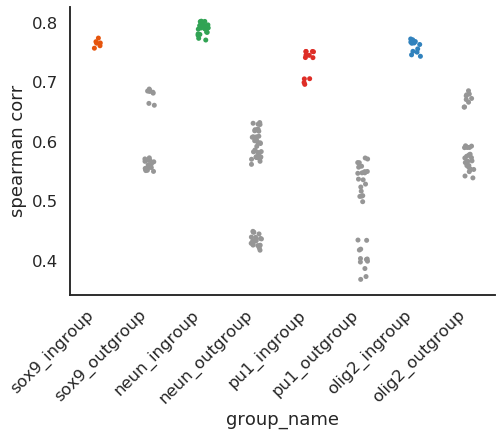

In [99]:
cp = sns.catplot(x="group_name",
            y="spearman corr",
            data=tidy_corr,
            aspect=1.5,
            # showmeans=True,
            palette=pal)

# fix x labels
cp.set_xticklabels(rotation=45, ha='right');

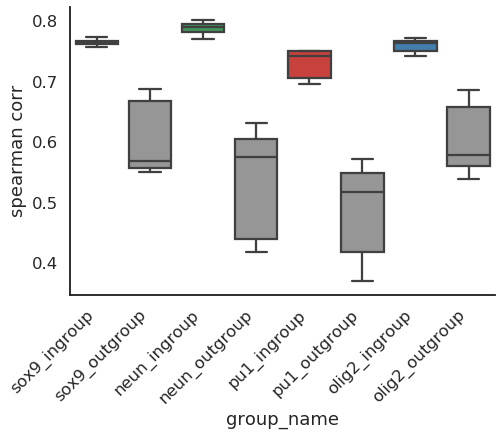

In [102]:
cp = sns.catplot(x="group_name",
            y="spearman corr",
            data=tidy_corr,
            aspect=1.5,
            kind='box',
            # showmeans=True,
            palette=pal)

# fix x labels
cp.set_xticklabels(rotation=45, ha='right');

Calculate significance of each 

In [104]:
from scipy.stats import kruskal

In [124]:
kruskal(sox9_ingroup, sox9_outgroup)

KruskalResult(statistic=13.935483870967744, pvalue=0.00018919298065443355)

In [125]:
kruskal(neun_ingroup, neun_outgroup)

KruskalResult(statistic=43.42105263157896, pvalue=4.4141345046317206e-11)

In [126]:
kruskal(pu1_ingroup, pu1_outgroup)

KruskalResult(statistic=25.82608695652175, pvalue=3.736046989551843e-07)

In [127]:
kruskal(olig2_ingroup, olig2_outgroup)

KruskalResult(statistic=25.82608695652175, pvalue=3.736046989551843e-07)